In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_apr2024.csv
/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_dec2024.csv
/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_dec2023.csv
/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_feb2024.csv
/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_jul2024.csv
/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_jan2025.csv
/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_mar2025.csv
/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_aug2024.csv
/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_jun2024.csv
/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_may2024.csv
/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_apr2025.csv
/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_jan2024.csv
/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_nov2024.csv

# Air Quality Analysis in Lagos, Nigeria (Nov 2023 – Apr 2025)

This notebook explores air quality trends in Lagos using PM₂.₅ data from Sensor.Africa.  
I clean, combine, and analyze readings from multiple monthly datasets, focusing on daily, weekly, and monthly PM₂.₅ patterns.

**Objectives**
- Understand how PM₂.₅ levels change over time.
- Detect pollution spikes and seasonal trends.
- Assess air quality compliance with WHO standards.

**Data Source:** Sensor.Africa Open Air Quality Data (Lagos Stations)


In [2]:
# imports
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
# Path to dataset folder
data_path = "/kaggle/input/sensors-africa-air-quality-archive-lagos/"

# List all CSV files in folder
csv_files = glob.glob(os.path.join(data_path, "*.csv"))

print("Number of files:", len(csv_files))
print("Found files:", list(csv_files))

Number of files: 18
Found files: ['/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_apr2024.csv', '/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_dec2024.csv', '/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_dec2023.csv', '/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_feb2024.csv', '/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_jul2024.csv', '/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_jan2025.csv', '/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_mar2025.csv', '/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_aug2024.csv', '/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_jun2024.csv', '/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_may2024.csv', '/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_apr2025.csv', '/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_jan2024.csv', '/kagg

## Data Loading and Preparation

I start by loading multiple monthly CSV files, combining them into a single DataFrame,  
and filtering only for PM₂.₅ (`value_type == 'P2'`).

I also convert timestamps to Lagos local time (WAT) for accurate daily and weekly analysis.


In [4]:
# Read and combine
df_list = []
for file in csv_files:
    temp = pd.read_csv(file)
    df_list.append(temp)

# Concatenate into one DataFrame
df = pd.concat(df_list, ignore_index=True)

In [5]:
# Check shape and preview
print("Combined shape:", df.shape)
df.head()

Combined shape: (340710, 1)


,sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value
0,4851;pms5003;3627;6.515;3.400;2024-04-02T05:39...
1,4851;pms5003;3627;6.515;3.400;2024-04-02T05:39...
2,4851;pms5003;3627;6.515;3.400;2024-04-02T05:39...
3,4852;DHT22;3627;6.515;3.400;2024-04-02T05:39:3...
4,4852;DHT22;3627;6.515;3.400;2024-04-02T05:39:3...


In [6]:
# Re read csv files specifying pandas to use semicolon as delimiter
df_list = []
for file in csv_files:
    temp = pd.read_csv(file, sep=";")  # specify delimiter
    df_list.append(temp)

# Concatenate into one DataFrame
df = pd.concat(df_list, ignore_index=True)

print("Combined shape:", df.shape)
print(df.head(15))


Combined shape: (340710, 8)
    sensor_id sensor_type  location    lat  lon  \
0        4851     pms5003      3627  6.515  3.4   
1        4851     pms5003      3627  6.515  3.4   
2        4851     pms5003      3627  6.515  3.4   
3        4852       DHT22      3627  6.515  3.4   
4        4852       DHT22      3627  6.515  3.4   
5        4851     pms5003      3627  6.515  3.4   
6        4851     pms5003      3627  6.515  3.4   
7        4851     pms5003      3627  6.515  3.4   
8        4852       DHT22      3627  6.515  3.4   
9        4852       DHT22      3627  6.515  3.4   
10       4851     pms5003      3627  6.515  3.4   
11       4851     pms5003      3627  6.515  3.4   
12       4851     pms5003      3627  6.515  3.4   
13       4852       DHT22      3627  6.515  3.4   
14       4852       DHT22      3627  6.515  3.4   

                           timestamp   value_type  value  
0   2024-04-02T05:39:23.644999+00:00           P2  21.22  
1   2024-04-02T05:39:23.644999+00:00 

In [7]:
# Keep only PM2.5 readings (P2)
df_pm25 = df[df["value_type"] == "P2"].copy()

# Sort by time
df_pm25 = df_pm25.sort_values("timestamp").reset_index(drop=True)

In [8]:
# Preview
print(df_pm25.shape)
df_pm25.head()

(73601, 8)


,sensor_id,sensor_type,location,lat,lon,timestamp,value_type,value
0,4855,pms5003,3629,6.428,3.435,2023-11-01T16:44:52.764459+00:00,P2,19.00
1,4857,pms5003,3630,6.540,3.297,2023-11-01T17:52:08.924982+00:00,P2,3.50
2,4857,pms5003,3630,6.540,3.297,2023-11-01T17:53:13.805911+00:00,P2,3.00
3,4853,pms5003,3628,6.559,3.386,2023-11-01T18:16:42.515782+00:00,P2,40.33
4,4857,pms5003,3630,6.540,3.297,2023-11-03T07:38:39.664224+00:00,P2,47.00


In [9]:
# check for NaNs
print(df_pm25.isna().sum())   

# quick summary
print(df_pm25["value"].describe())  


sensor_id      0
sensor_type    0
location       0
lat            0
lon            0
timestamp      0
value_type     0
value          0
dtype: int64
count    73601.000000
mean        34.024268
std         26.748584
min          0.000000
25%         19.000000
50%         29.000000
75%         40.000000
max        690.000000
Name: value, dtype: float64


In [10]:
# Ensure timestamp is datetime
df_pm25["timestamp"] = pd.to_datetime(df_pm25["timestamp"], errors="coerce")

# Set as index
df_pm25 = df_pm25.set_index("timestamp")

# convert to Lagos time
df_pm25 = df_pm25.tz_convert("Africa/Lagos")

# Verify
print(df_pm25.index[:5])


DatetimeIndex(['2023-11-01 17:44:52.764459+01:00',
               '2023-11-01 18:52:08.924982+01:00',
               '2023-11-01 18:53:13.805911+01:00',
               '2023-11-01 19:16:42.515782+01:00',
               '2023-11-03 08:38:39.664224+01:00'],
              dtype='datetime64[ns, Africa/Lagos]', name='timestamp', freq=None)


## Exploratory Data Analysis
I begin by understanding the raw PM₂.₅ distribution to identify outliers and assess the general air quality level.


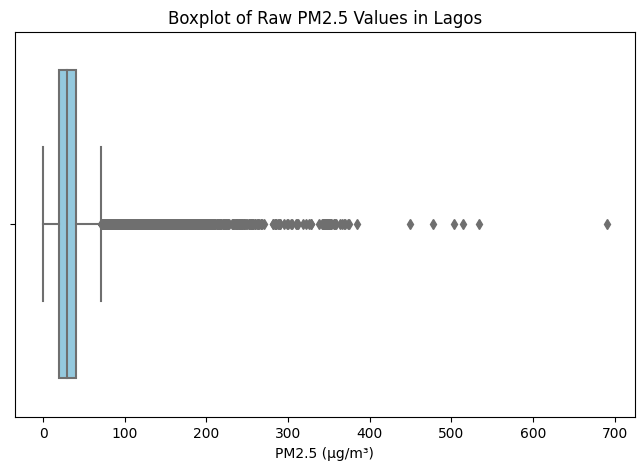

In [11]:
# create boxplot of PM2.5 to see distribution
plt.figure(figsize=(8,5))
sns.boxplot(x=df_pm25["value"], color="skyblue")
plt.title("Boxplot of Raw PM2.5 Values in Lagos")
plt.xlabel("PM2.5 (µg/m³)")
plt.show()

The boxplot shows several extreme outliers, likely sensor errors or one-off events.  
I removed PM₂.₅ readings above **500 µg/m³** to ensure cleaner analysis.


In [12]:
# Remove extreme outliers (> 500)
df_pm25_clean = df_pm25[df_pm25["value"] <= 500].copy()

print("Before cleaning:", df_pm25.shape[0], "rows")
print("After cleaning:", df_pm25_clean.shape[0], "rows")


Before cleaning: 73601 rows
After cleaning: 73597 rows


## Time-Series Behavior of PM₂.₅ in Lagos

To capture temporal patterns, I visualize daily, weekly, and monthly averages of PM₂.₅ levels.
This helps identify recurring pollution patterns and long-term trends.


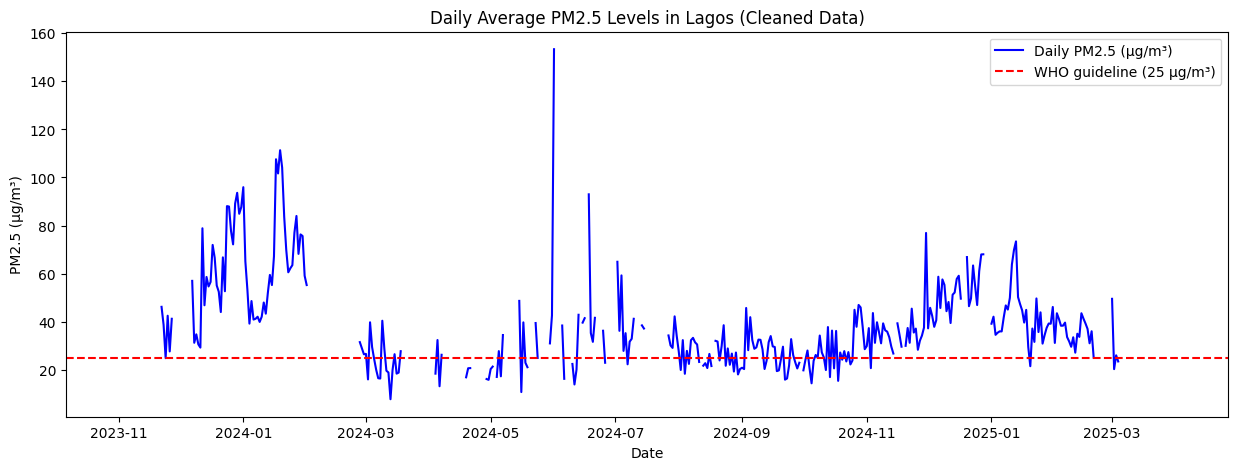

In [13]:
# Daily resample
df_daily = df_pm25_clean["value"].resample("1D").mean()

# Daily time series plot
plt.figure(figsize=(15,5))
plt.plot(df_daily.index, df_daily.values, label="Daily PM2.5 (µg/m³)", color="blue")
plt.axhline(25, color="red", linestyle="--", label="WHO guideline (25 µg/m³)")
plt.title("Daily Average PM2.5 Levels in Lagos (Cleaned Data)")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.show()


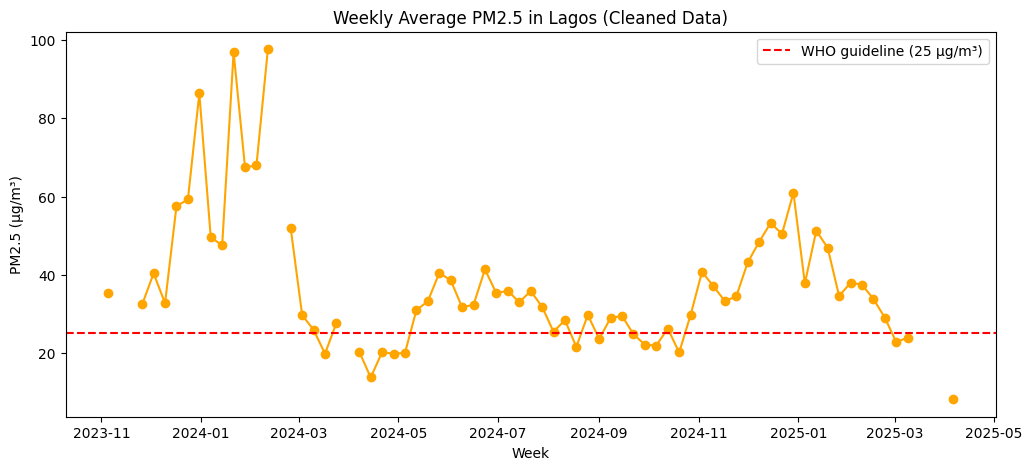

In [14]:
# Weekly resample
df_weekly = df_pm25_clean["value"].resample("W").mean()

# Weekly time series plot
plt.figure(figsize=(12,5))
plt.plot(df_weekly.index, df_weekly.values, marker="o", color="orange")
plt.axhline(25, color="red", linestyle="--", label="WHO guideline (25 µg/m³)")
plt.title("Weekly Average PM2.5 in Lagos (Cleaned Data)")
plt.xlabel("Week")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.show()


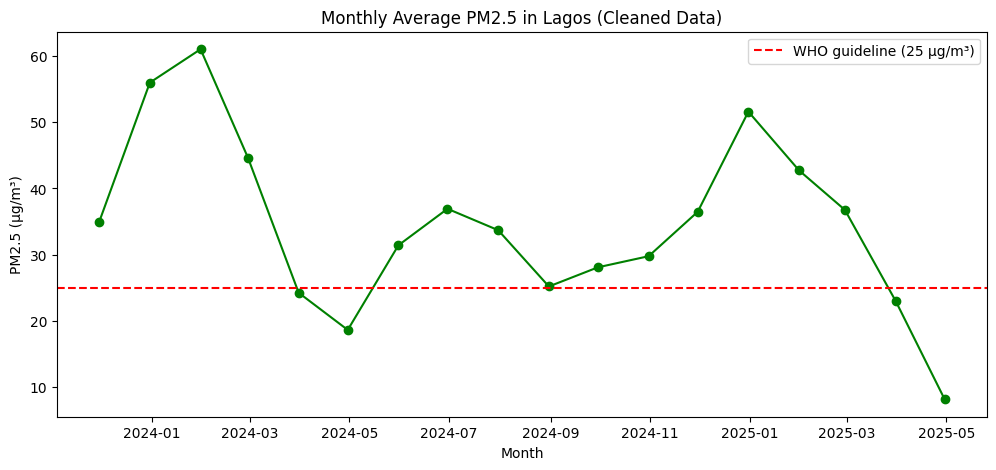

In [15]:
# Monthly resample
df_monthly = df_pm25_clean["value"].resample("ME").mean()

# Monthly time series plot
plt.figure(figsize=(12,5))
plt.plot(df_monthly.index, df_monthly.values, marker="o", color="green")
plt.axhline(25, color="red", linestyle="--", label="WHO guideline (25 µg/m³)")
plt.title("Monthly Average PM2.5 in Lagos (Cleaned Data)")
plt.xlabel("Month")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.show()


### 30-Day Rolling Average

To smooth short-term fluctuations and highlight long-term pollution trends,  
I applied a 30-day rolling average to the daily PM₂.₅ data.

The red line below shows the smoothed trend, which makes seasonal variations and  
persistent high-pollution periods easier to identify.


In [25]:
# Calculate 30-day rolling mean
daily_rolling = df_daily.rolling(window=30, min_periods=1).mean()


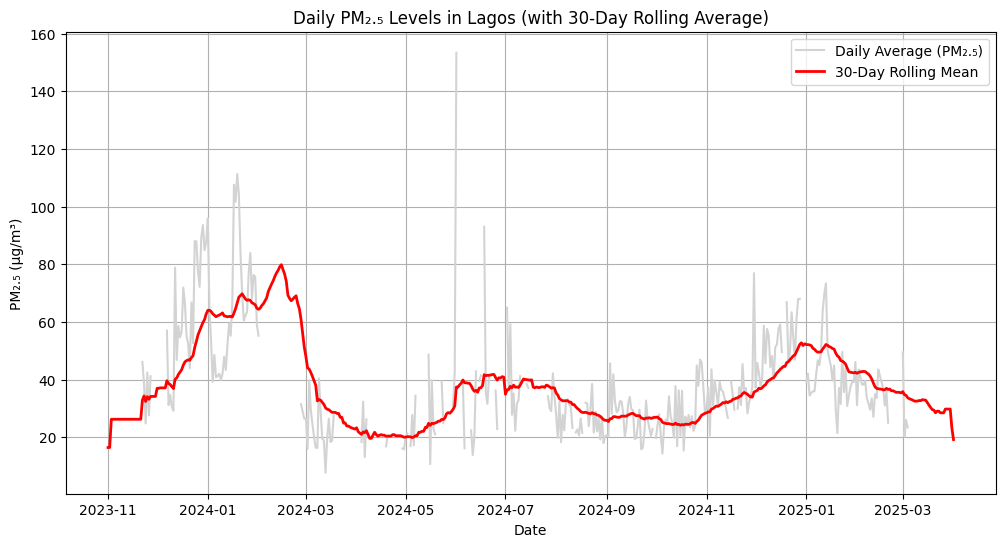

In [27]:
# Plot Both the Daily Data and Rolling Average
plt.figure(figsize=(12,6))
plt.plot(df_daily.index, df_daily, color='lightgray', label='Daily Average (PM₂.₅)')
plt.plot(daily_rolling.index, daily_rolling, color='red', linewidth=2, label='30-Day Rolling Mean')

plt.title('Daily PM₂.₅ Levels in Lagos (with 30-Day Rolling Average)')
plt.xlabel('Date')
plt.ylabel('PM₂.₅ (µg/m³)')
plt.legend()
plt.grid(True)
plt.show()


### Observations on the Rolling Average

Despite applying a 30-day rolling average, the PM₂.₅ trend remains irregular,  
indicating the absence of a clear long-term pattern or seasonal cycle in the dataset.  

This suggests that air quality fluctuations in Lagos during this period may be influenced by  
short-term, localized factors, such as traffic density, weather changes, or sensor inconsistencies rather than a smooth or predictable trend.


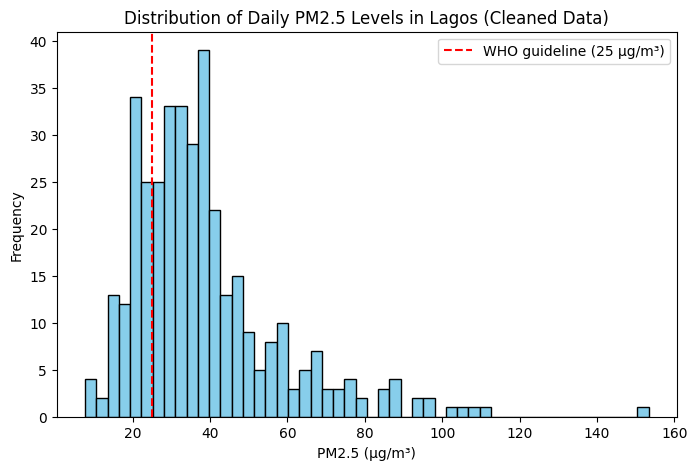

In [16]:
# Histogram (distribution of daily averages)
plt.figure(figsize=(8,5))
plt.hist(df_daily.dropna(), bins=50, color="skyblue", edgecolor="black")
plt.axvline(25, color="red", linestyle="--", label="WHO guideline (25 µg/m³)")
plt.title("Distribution of Daily PM2.5 Levels in Lagos (Cleaned Data)")
plt.xlabel("PM2.5 (µg/m³)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [18]:
# Daily summary
daily_stats = df_pm25_clean["value"].resample("1D").agg(["mean", "median", "max", "min"])

# Weekly summary
weekly_stats = df_pm25_clean["value"].resample("1W").agg(["mean", "median", "max", "min"])

# Monthly summary
monthly_stats = df_pm25_clean["value"].resample("1ME").agg(["mean", "median", "max", "min"])

# Preview one (e.g. monthly)
monthly_stats.tail()


,mean,median,max,min
timestamp,,,,
2024-12-31 00:00:00+01:00,51.593506,49.83,154.56,33.67
2025-01-31 00:00:00+01:00,42.725590,39.67,267.00,6.00
2025-02-28 00:00:00+01:00,36.773171,36.00,80.56,10.00
2025-03-31 00:00:00+01:00,23.053529,22.00,49.50,14.50
2025-04-30 00:00:00+01:00,8.200000,8.00,10.50,7.00


In [19]:
summary_table = pd.DataFrame({
    "Daily Mean": [daily_stats["mean"].mean()],
    "Weekly Mean": [weekly_stats["mean"].mean()],
    "Monthly Mean": [monthly_stats["mean"].mean()],
    "Overall Mean": [df_pm25_clean["value"].mean()]
})

summary_table = summary_table.T.rename(columns={0: "PM2.5 (µg/m³)"})
summary_table


,PM2.5 (µg/m³)
Daily Mean,38.439189
Weekly Mean,37.341047
Monthly Mean,34.640253
Overall Mean,33.995665


In [21]:
# Drop NaN values and Add exceedance summary
exceed_days = (daily_stats["mean"].dropna() > 25).sum()
total_days = daily_stats["mean"].dropna().shape[0]
percent_exceed = (exceed_days / total_days) * 100

print(f"Lagos exceeded WHO PM2.5 guideline on {exceed_days} of {total_days} days ({percent_exceed:.1f}%)")


Lagos exceeded WHO PM2.5 guideline on 287 of 374 days (76.7%)


## Air Quality Compliance: Clean vs Polluted Days

To better understand air quality trends in Lagos, I assess how often daily PM₂.₅ levels comply with the World Health Organization (WHO) guideline value of **25 µg/m³**.

Days with mean PM₂.₅ ≤ 25 µg/m³ are classified as **Clean**, while those exceeding this limit are **Polluted**.  
This analysis provides a quick overview of overall air quality compliance from **November 2023 to April 2025**.


In [22]:
# Define WHO guideline threshold (µg/m³)
threshold = 25  

# Count days above and below threshold
clean_days = (daily_stats["mean"].dropna() <= threshold).sum()
polluted_days = (daily_stats["mean"].dropna() > threshold).sum()

print(f"Clean days: {clean_days}, Polluted days: {polluted_days}")


Clean days: 87, Polluted days: 287


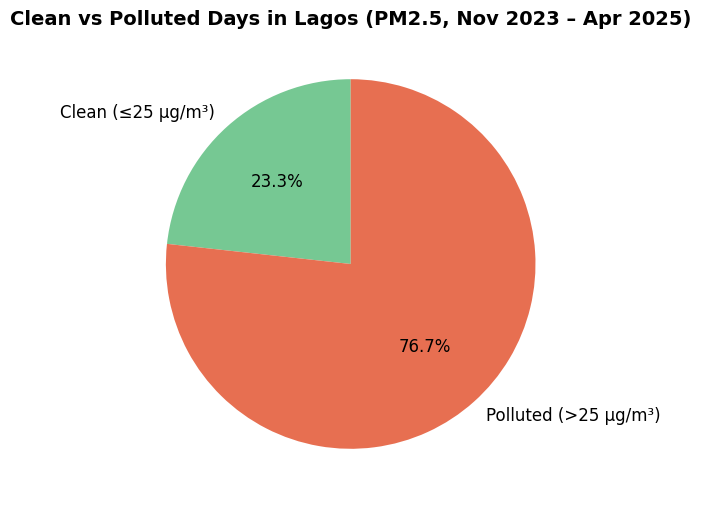

In [23]:
# Prepare data
labels = ['Clean (≤25 µg/m³)', 'Polluted (>25 µg/m³)']
values = [clean_days, polluted_days]
colors = ['#76c893', '#e76f51']

# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, textprops={'fontsize':12})
plt.title("Clean vs Polluted Days in Lagos (PM2.5, Nov 2023 – Apr 2025)", fontsize=14, weight='bold')
plt.show()

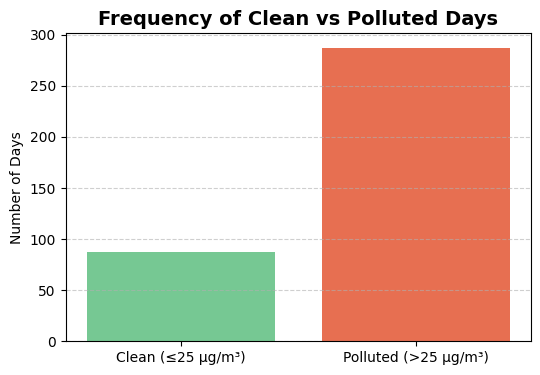

In [24]:
plt.figure(figsize=(6,4))
plt.bar(labels, values, color=colors)
plt.title("Frequency of Clean vs Polluted Days", fontsize=14, weight='bold')
plt.ylabel("Number of Days")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()
